In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [9]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [10]:
print(train_df.info())
print(train_df.describe())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [11]:
print(test_df.info())
print(test_df.describe())
print(test_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209  

In [12]:
# Handling Missing Data
age_imputer = SimpleImputer(strategy = 'median')

train_df['Age'] = age_imputer.fit_transform(train_df[['Age']])
test_df['Age'] = age_imputer.transform(test_df[['Age']])

train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

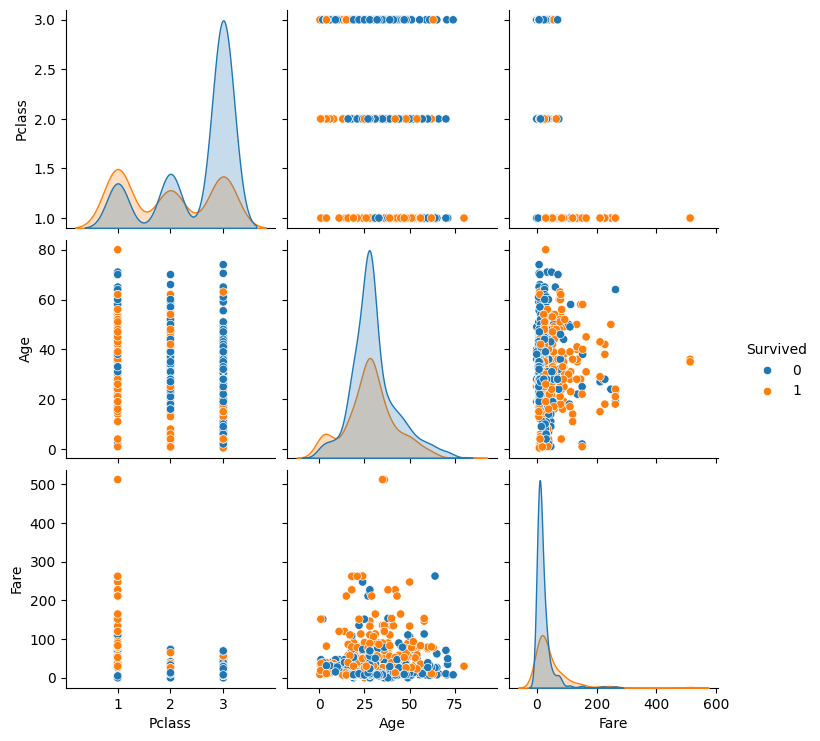

In [13]:
sns.pairplot(train_df[['Survived', 'Pclass', 'Age', 'Fare', 'Sex', 'Embarked']], hue = 'Survived')
plt.show()

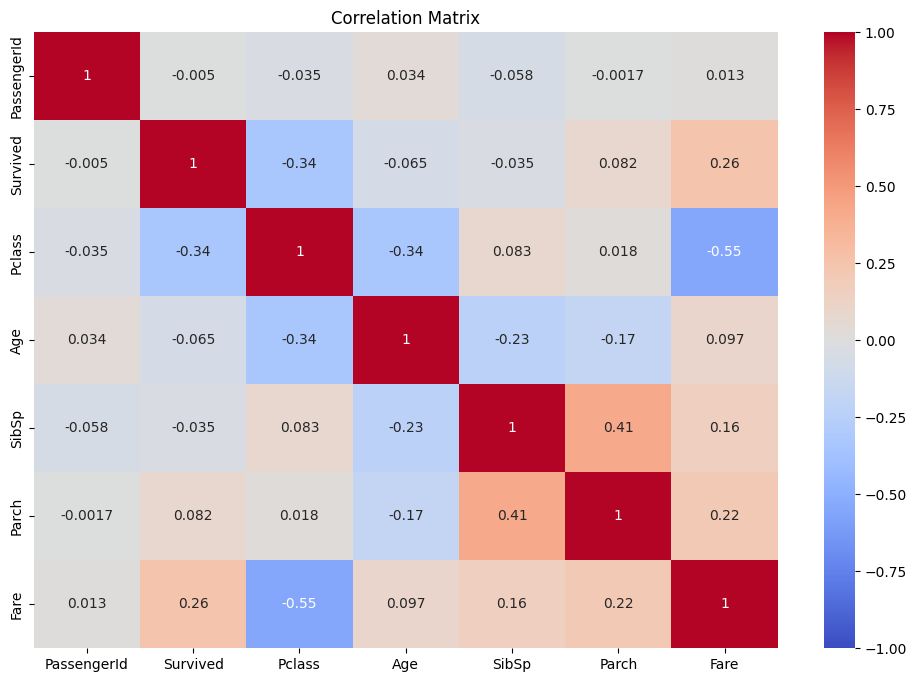

In [14]:
plt.figure(figsize = (12, 8))
corr_matrix = train_df.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix')
plt.show()

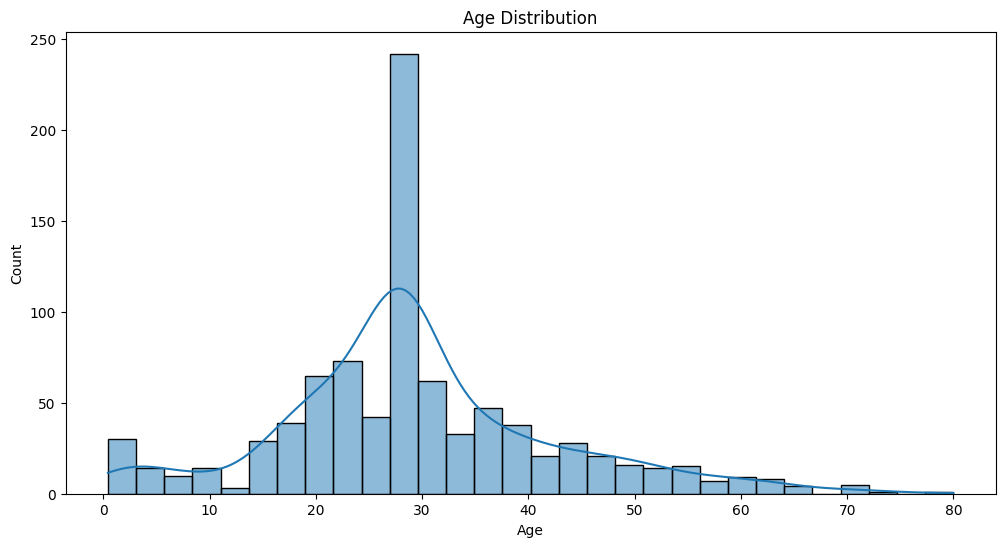

In [15]:
plt.figure(figsize = (12, 6))
sns.histplot(train_df['Age'], kde = True, bins = 30)
plt.title('Age Distribution')
plt.show()

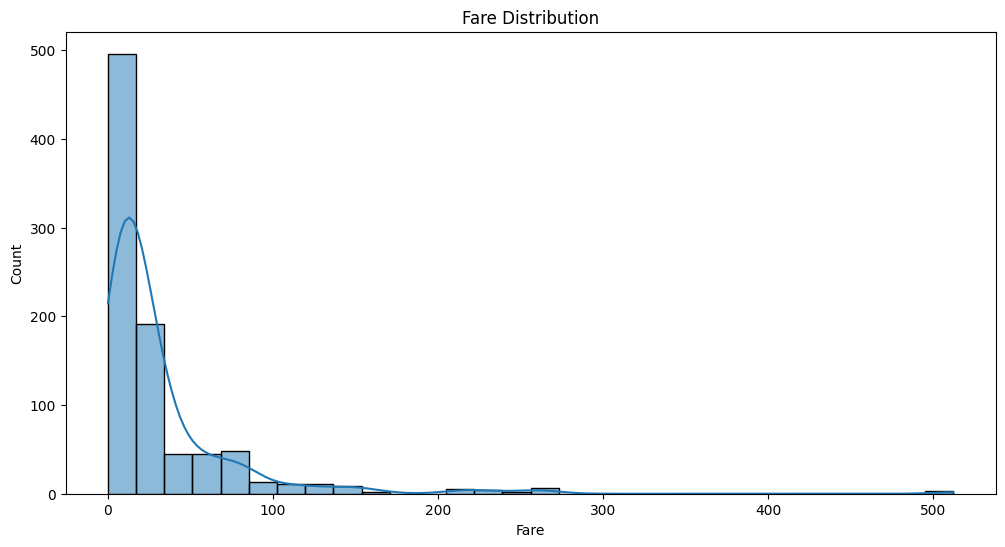

In [16]:
plt.figure(figsize = (12, 6))
sns.histplot(train_df['Fare'], kde = True, bins = 30)
plt.title('Fare Distribution')
plt.show()

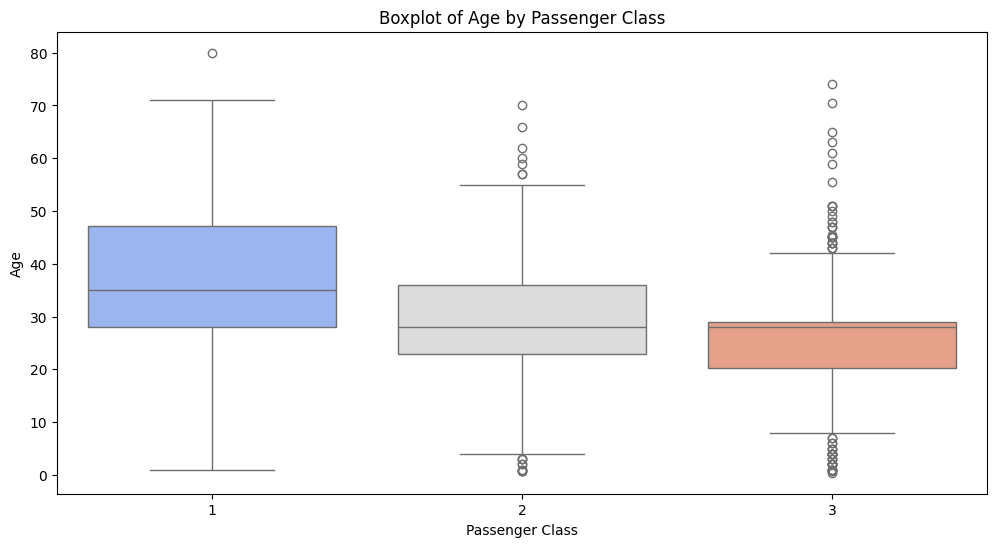

In [17]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Pclass', y = 'Age', data = train_df, palette = 'coolwarm')
plt.xlabel('Passenger Class')
plt.title('Boxplot of Age by Passenger Class')
plt.show()

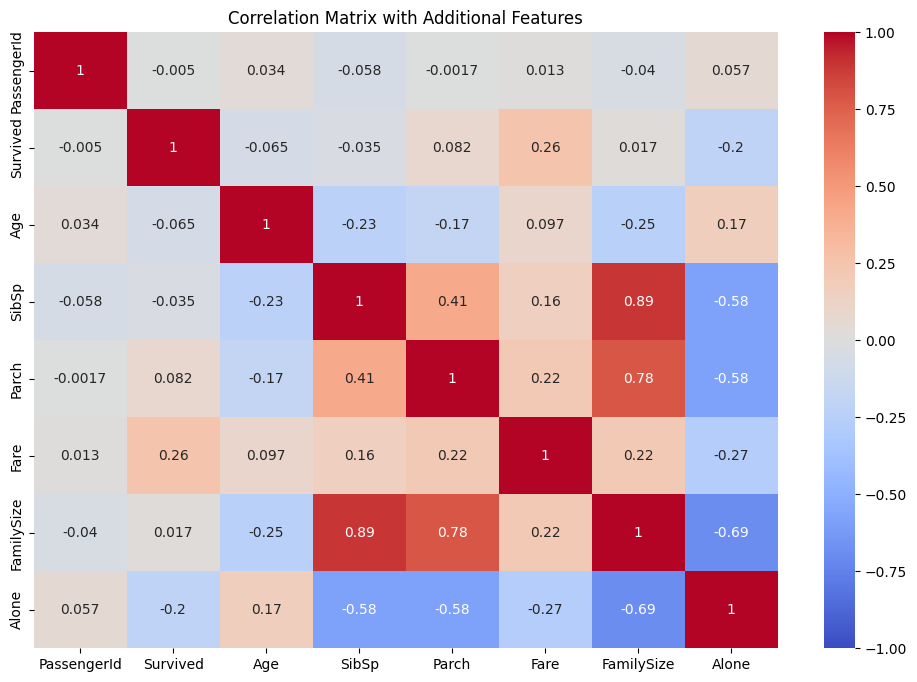

In [18]:
# Feature Engineering

train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + train_df['Parch'] + 1

train_df['Alone'] = (train_df['FamilySize'] == 1).astype(int)
test_df['Alone'] = (test_df['FamilySize'] == 1).astype(int)

train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

title_mapping = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 
    'Master': 'Master', 'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'
}

train_df['Title'] = train_df['Title'].apply(lambda x: title_mapping.get(x, 'Other'))
test_df['Title'] = test_df['Title'].apply(lambda x: title_mapping.get(x, 'Other'))

train_df['AgeBin'] = pd.cut(train_df['Age'], bins = [0, 12, 20, 40, np.inf], labels = ['Child', 'Teenager', 'Adult', 'Senior'])
test_df['AgeBin'] = pd.cut(test_df['Age'], bins = [0, 12, 20, 40, np.inf], labels = ['Child', 'Teenager', 'Adult', 'Senior'])

train_df['FairBin'] = pd.cut(train_df['Fare'], bins = 4, labels = ['Low', 'Mid', 'High', 'Very_High'])
test_df['FairBin'] = pd.cut(test_df['Fare'], bins = 4, labels = ['Low', 'Mid', 'High', 'Very_High'])

train_df['Pclass'] = train_df['Pclass'].astype('category')
test_df['Pclass'] = test_df['Pclass'].astype('category')

# Plotting correlations between expanded feature set
plt.figure(figsize = (12, 8))
corr_matrix = train_df.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix with Additional Features')
plt.show()

In [19]:
# Modelling

features_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Preprocessing features
X = train_df.drop(columns = ['Survived'] + features_to_drop)
y = train_df['Survived']

categorical_features = X.select_dtypes(include = ['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include = 'number').columns.tolist()

categorical_transformer = Pipeline([('onehot', OneHotEncoder())])
numeric_transformer = Pipeline([('scaler', StandardScaler()), 
                                ('poly', PolynomialFeatures(degree = 2, include_bias = False))])

preprocessor = ColumnTransformer([('categorical', categorical_transformer, categorical_features), 
                                  ('numeric', numeric_transformer, numeric_features)])

X_proc = preprocessor.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_proc, y, test_size = 0.2, random_state = 4423, stratify = y)

# Defining Base Models 
rf_classifier = RandomForestClassifier(random_state = 4423)
svm_classifier = SVC(probability = True, random_state = 4423)
xgb_classifier = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 4423)

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [1, 2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

cross_val = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4423)

grid_rf = GridSearchCV(rf_classifier, param_grid_rf, scoring = 'accuracy', cv = cross_val)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

grid_svm = GridSearchCV(svm_classifier, param_grid_svm, scoring = 'accuracy', cv = cross_val)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

grid_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, scoring = 'accuracy', cv = cross_val)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

def get_oof_predictions(estimator, X, y, cv):
    return cross_val_predict(estimator, X, y, cv = cv, method = 'predict_proba')

rf_oof = get_oof_predictions(best_rf, X_proc, y, cross_val)
svm_oof = get_oof_predictions(best_svm, X_proc, y, cross_val)
xgb_oof = get_oof_predictions(best_xgb, X_proc, y, cross_val)

X_train_stack = np.hstack([rf_oof, svm_oof, xgb_oof])

stacking_classifier = StackingClassifier([('rf', best_rf), ('svm', best_svm), ('xgb', best_xgb)], 
                                         final_estimator = LogisticRegression())

param_grid_stacking = {'final_estimator__C': np.geomspace(1e-3, 1e3, 7)}

stacking_grid = GridSearchCV(stacking_classifier, param_grid_stacking, scoring = 'accuracy', cv = cross_val)

stacking_grid.fit(X_train_stack, y)

stacking_classifier_best = stacking_grid.best_estimator_


In [20]:
print(classification_report(y, stacking_classifier_best.predict(X_train_stack)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       549
           1       0.85      0.75      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.84       891
weighted avg       0.86      0.86      0.85       891



In [21]:
# Predictions 

# Retraining base models on entire dataset for better performance
best_rf.fit(X_proc, y)
best_svm.fit(X_proc, y)
best_xgb.fit(X_proc, y)

X_test = test_df.drop(columns = features_to_drop)
X_test_proc = preprocessor.transform(X_test)

# Generate predictions for test data using base models
test_pred_rf = best_rf.predict_proba(X_test_proc)
test_pred_svm = best_svm.predict_proba(X_test_proc)
test_pred_xgb = best_xgb.predict_proba(X_test_proc)

X_test_stack = np.hstack([test_pred_rf, test_pred_svm, test_pred_xgb])

test_pred = stacking_classifier_best.predict((X_test_stack))

In [22]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': test_pred})

submission.to_csv('survived.csv', index = False)